# Задание на курсовой проект

Система управления разрабатывается для обеспечения желаемого уровня давления, задаваемого оператором.

В механизме управления имеется 2 датчика и один исполнительный механизм:

* датчик объемного расхода
* датчик давления
* электропривод

Динамика показаний датчиков описывается следующей моделью:

$$ \dot P = -0.1 P^3 - 5 P^2 - 2 P + i + 22 dV + 5 $$
$$ \dot {dV} = 5PdV - 7P -0.1dV^3 - 7dV^2 -dV + 30 tanh(F) + 9$$

где $dV$ - объёмный расход наза в трубе, $P$ - давление газа в резервуаре, $F$ - усилие исполнительного механизма, $i \in [6:17]$ - неконтролируемое возмущение в системе.

Необходимо разработать и провести моделирование систем управления с адаптацией к неконтролируемому возмущению согласно следующему перечню методов:
* система с ПИД-регулятором,
* метод АКАР с фиксацией неизвестного параметра на уровне среднего,
* метод АКАР с интегральной адаптацией,
* система прямого адаптивного управления с обобшённой ошибкой настройки,
* система прямого адаптивного управления на основе метода скоростного градиента

## Часть 1
Средство автоматизации расчетов sympy. Численное моделирование системы ОДУ в среде Python/scipy.

### Модель системы

Заменим параметр $i$ на сумму значения из середины его интервала изменения $i_0$ = 11.5 и неконтролируемого возмущения $di$, лежашего в интервале $[-5.5;5.5]$

$\dot P = -0.1P^3-5P^2-2P+i_0+di+22dV+5$

$\dot dV = 5PdV - 7P - 0.1dv^3-7dV^2-dV+30tanh(F) + 9$

### 1. Автоматизация расчета закона управления по методу АКАР с помощью пакета sympy

В ходе выполнения курсового проекта будем использовать пакет символьных вычислений sympy. Используя методы указанного пакета перенесем модель системы в среду jupiter notebook.

In [1]:
import sympy
from sympy import sin

P = sympy.symbols('P')
dV = sympy.symbols('dV')
F = sympy.symbols('F')
Pd = sympy.symbols('Pd')
i = sympy.symbols('i')
di = sympy.symbols('di')
F = sympy.symbols('F')
G = sympy.symbols('G')
i0 = 11.5

dP = -0.1 * P**3 - 5 * P**2 - 2 * P + i0 + di + 22 * dV + 5
ddV = 5 * P * dV - 7 * P -0.1 * dV**3 - 7 * dV ** 2 -dV + G * F + 9

print('Уравнения системы:')
print('dP/dt=' + str(dP))
print('dsV/dt=' + str(ddV))
print('')

Уравнения системы:
dP/dt=-0.1*P**3 - 5*P**2 - 2*P + 22*dV + di + 16.5
dsV/dt=F*G + 5*P*dV - 7*P - 0.1*dV**3 - 7*dV**2 - dV + 9



Воспользуемся методом эталонной модели. Выберем апериодическое звено первого порядка в качестве желаемой модели поведения параметра P:

$\dot P + c_1*P + c_2 = 0$

Найдем закон изменения параметра B, обеспечивающее желаемое поведение. Для этого выразим из эталонной модели первую производную P:

$\dot P = -c_1*P - c_2$

Приравняем правые части уравнения эталонной модели и уравнения из исходной системы:

$-0.1P^3-5P^2-2P+di+22dV+16.5 = -c_1*P - c_2$

Выразим параметр dV:

$DdV = (1/22) * (-c_1*P-c_2+0.1P^3+5P^2+2P-di-16.5) $

Основываясь на методе АКАР сформируем целевую функцию:

$psi = DdV - dV = (1/22) * (-c_1*P-c_2+0.1P^3+5P^2+2P-di-16.5) - dV$

Выберем эталонную модель движения к поверхности psi:

$psi + dpsi/dt = 0$

Расчитаем полную производную по времени функции psy:

$dpsi/dt = dpsi/dP * dP/dt + dpsi/ddV * ddV/dt = 1/22 * (-c_1 + 0.3P^2+10P+2)(-0.1P^3-5P^2-2P+di+22dV+16.5) - 5PdV+7P+0.1dV^3+7dV^2+dV-Gtanh(F)-9$

Подставляя уравнение функции psi и уравнение ее полной производной по времени в уравнение эталонной модели получим:

$(1/22) * (-c_1*P-c_2+0.1P^3+5P^2+2P-di-16.5) - dV + 1/22 * (-c_1 + 0.3P^2+10P+2)(-0.1P^3-5P^2-2P+di+22dV+16.5) - 5PdV+7P+0.1dV^3+7dV^2+dV-Gtanh(F)-9 = 0$

Из полученного уравнения выразим управление F:

$F = atanh((1/G) * (1/22*(-c_1P-c_2+0.1P^3+5P^2+2P-di-16.5)-dV +1/22 * (-c_1+0.3P^2+10P+2)(-0.1P^3-5P^2-2P+di+22dV+16.5) - 5PdV+7P+0.1dV^3+7dV^2+dV-9))$

In [2]:
from sympy.solvers import solve
c1 = sympy.symbols('c1')
c2 = sympy.symbols('c2')
DdP = -c1*P -c2
DdV=solve(dP-DdP, dV)
print('Желаемая функция B(t) для эталонной модели dP='+str(DdP))
print('dV='+str(DdV))
print('')
psi=DdV[0]-dV
dpsi = sympy.diff(psi,P)*dP + sympy.diff(psi,dV)*ddV
u=solve(sympy.expand(dpsi+psi),F)
u_analytical = u[0]
print('Закон управления по методу АКАР для макропеременной psi=' + str(psi))
print('F='+str(sympy.expand(u_analytical)))
print()

# Перенесем выражение, вычисленное вручную, с заменой y = tanh(x) на y = x:
u_calc = (1/30) * (1/22*(-c1*P-c2+0.1*P**3+5*P**2+2*P-di-16.5) - dV+1/22*(-c1+0.3*P**2+10*P+2)*(-0.1*P**3-5*P**2-2*P+di+22*dV+16.5) - 5*P*dV + 7*P+0.1*P+0.1*P+0.1*dV**3+7*dV**2+dV-9)
print('Разница между выражением, вычисленным вручную, и выражением, вычислинным с помощью библиотеки sympy:')
print(str(sympy.expand(u_calc) - sympy.expand(u_analytical)))
print()

Желаемая функция B(t) для эталонной модели dP=-P*c1 - c2
dV=[0.00454545454545455*P**3 + 0.227272727272727*P**2 - 0.0454545454545455*P*c1 + 0.0909090909090909*P - 0.0454545454545455*c2 - 0.0454545454545455*di - 0.75]

Закон управления по методу АКАР для макропеременной psi=0.00454545454545455*P**3 + 0.227272727272727*P**2 - 0.0454545454545455*P*c1 + 0.0909090909090909*P - 0.0454545454545455*c2 - dV - 0.0454545454545455*di - 0.75
F=-0.00136363636363636*P**5/G - 0.113636363636364*P**4/G + 0.00454545454545455*P**3*c1/G - 2.30454545454545*P**3/G + 0.227272727272727*P**2*c1/G + 0.3*P**2*dV/G + 0.0136363636363636*P**2*di/G - 0.911363636363636*P**2/G + 0.0454545454545455*P*c1/G + 5.0*P*dV/G + 0.454545454545455*P*di/G + 14.4090909090909*P/G - 1.0*c1*dV/G - 0.0454545454545455*c1*di/G - 0.75*c1/G - 0.0454545454545455*c2/G + 0.1*dV**3/G + 7.0*dV**2/G + 2.0*dV/G + 0.0454545454545455*di/G - 8.25/G

Разница между выражением, вычисленным вручную, и выражением, вычислинным с помощью библиотеки sympy:
-

Можно заметить, что разность между выражением для F, вычисленным вручную и вычисленным с помощью методов библиотеки sympy, близка к 0. (Разность не совпадает с 0 из-за ошибок округления).

### 2. Численное моделирование системы ОДУ

Произведем численное моделирование системы при постоянном управляющем воздействии:

Проведем анализ положений равновесия системы при постоянном воздействии C. Для этого приравняем производные параметров системы к нулю:

$0 = -0.1P^3-5P^2-2P+i_0+di+22dV+5$

$0 = 5PdV - 7P -0.1dV^3 - 7dV^2 -dV + 30 tanh(F) + 9$

Изобразим графики зависимости dV(P) на основе полученных выражений. Положениями равновесия системы при постоянном воздействии F являются точки пересечения этих графиков. В системе при любом значении параметров есть 3 положения равновесия, из которых всего в одном P является положительным.
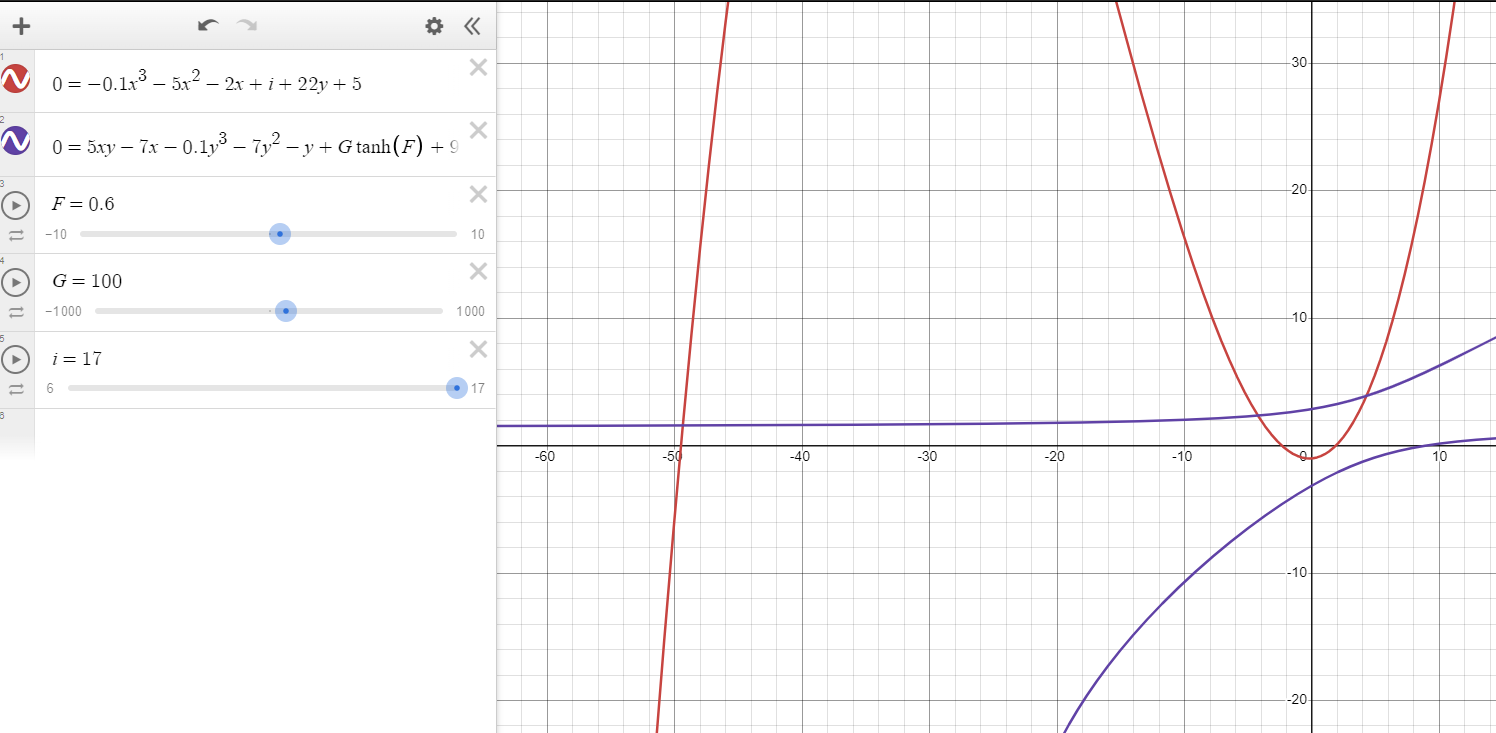



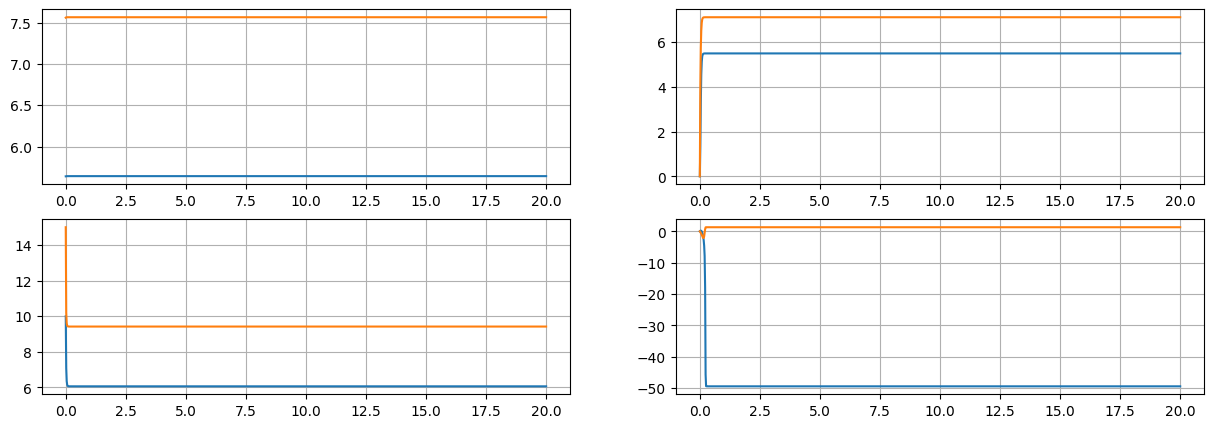

In [3]:
import matplotlib.pyplot as plt
import scipy.integrate as mdl
import math
import numpy as np

def calc(x, t, i, F, G):
    return [-0.1*x[0]**3 - 5*x[0]**2 - 2*x[0] + i + 22*x[1] + 5, 5*x[0]*x[1] - 7*x[0] - 0.1*x[1]**3 - 7*x[1]**2 - x[1] + G*math.tanh(F) + 9]

t = np.linspace(0, 20, 1000)

plt.figure(figsize=(15,5))

plt.subplot(2,2,1)
y = mdl.odeint(calc, [5.64, 7.56], t, args=(17,0.6,500))
plt.plot(t,y)
plt.grid()

plt.subplot(2,2,2)
y = mdl.odeint(calc, [0, 0], t, args=(17,0.5,500))
plt.plot(t,y)
plt.grid()

plt.subplot(2,2,3)
y = mdl.odeint(calc, [10, 15], t, args=(6,0.5,1000))
plt.plot(t,y)
plt.grid()

plt.subplot(2,2,4)
y = mdl.odeint(calc, [0, 0], t, args=(6,-0.2,100))
plt.plot(t,y)
plt.grid()

plt.show()

На данных графиках синим цветом изображён показатель P, оранжевым - dV.
Исходя из графиков, можно подтвердить вывод о том, что система имеет несколько устойчивых положений равновесия, и всего в одном из них P положительное. Далее будет рассматриваться только это положение равновесия. Координаты положения равновесия можно менять путём изменения усиления G, управления F и параметра i.

## Часть 2. 
Моделирование системы

In [4]:
# Определение функций и значений, которые будут использоваться в ходе всей работы
!pip install digicon_mod
import digicon_mod
import math
import matplotlib.pyplot as plt

# Функция для построения графиков
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, time_end], [1, 1], 'r--',[0, time_end], [-1, -1], 'r--',[0, time_end],[0, 0],'r:')
    plt.show()

# Функция для модериования динамики системы
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                di = finish_value
            else:
                di = init_value
            return [
                -0.1 * x[0]**3 - 5 * x[0]**2 - 2 * x[0] + di + 22 * x[1] + 5,
                5 * x[0] * x[1] - 7 * x[0] - 0.1 * x[1]**3 - 7 * x[1]**2 - x[1] + uc + 9
            ]

        return F_internal
    return F_with_control


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### ПИД-регулятор

Произведем численное моделирование системы с ПИД-регулятором.

Определим ПИД-регулятор в программе как класс:

In [5]:
class PID(digicon_mod.plc.PLC):
    def __init__(self, goal, Kp, Ki, Kd, gain, step):
        super().__init__(gain=gain, step=step)
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.ei = 0
        self.prev_e = 0
        self.goal = goal

    def control(self, x, t):
        e = x[0] - self.goal
        self.ei = self.ei + e
        P = self.Kp * e
        I = self.Ki * self.ei
        D = self.Kd * (e - self.prev_e)
        return P + I + D

Произведем моделирование процессов в системе с ПИД-регулятором и отразим результаты на графиках:

In [6]:
# Параметры для моделирования скачкообразного изменения неконтроллируемого возмущения
di_init = -5.0
di_finish = 5.0
change_time = 15
# Цель управления
goal = 6.5
# Усиление, характеризующее возможности исполнительного механизма
gain = 1000
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Параметры моделирования (время моделирования и начальные условия)
tk=30
x0=[2, 9]
# Функция для моделирования процессов в системе, хранящая информацию о скачкообразном изменении возмущения
func_ctrl = F_with_change(change_time,da_init,da_finish)

# Создание объекта ПЛК
plc=PID(goal=goal, Kp=0.0001, Ki=-0.001, Kd=0.01, gain=gain, step=step)
# Моделирование процессов в системе
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
# Построение графиков
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)

# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.1
mod_step = 0.01
# Создание объекта ПЛК
plc=PID(goal=goal, Kp=-0.01, Ki=-0.001, Kd=-0.01, gain=gain, step=step)
# Моделирование процессов в системе
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
# Построение графиков
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)

# Усиление, характеризующее возможности исполнительного механизма
gain = 100
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Создание объекта ПЛК
plc=PID(goal=goal, Kp=-0.01, Ki=-0.001, Kd=-0.01, gain=gain, step=step)
# Моделирование процессов в системе
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
# Построение графиков
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)

NameError: name 'da_init' is not defined


С помощью ПИД реугулятора удалось отрегулировать процесс. Система с ПИД-регулятором смогла алаптироваться к именению параметра $i$. По графикам можно сделать следующие выводы: при изменении шагов моделирования портится картина процессов; при уменьшении коэффициента усиления не хватает усилия механизма не хватит для достижения цели.


### Метод АКАР с фиксацией неизвестного параметра на уровне среднего

Ранее нами уже был получен закон управления по методу АКАР (вручную и с помощью пакета sympy). Сделаем доработку в виде добавления постоянной времени в эталоную модель движения к поверхности psi для регулирования темпа процессов в системе и их устойчивости. Приведем эталонную модель поведения параметра P к виду с явно выраженной целью управления.

In [7]:
import sympy

P = sympy.symbols('P')
dV = sympy.symbols('dV')
F = sympy.symbols('F')
Pd = sympy.symbols('Pd')
i = sympy.symbols('i')
di = sympy.symbols('di')
F = sympy.symbols('F')
G = sympy.symbols('G')

dP = -0.1 * P**3 - 5 * P**2 - 2 * P + di + 22 * dV + 16.5
ddV = 5 * P * dV - 7 * P -0.1 * dV**3 - 7 * dV ** 2 -dV + G * F + 9
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')

psi1 = P - Pd
dpsi1 = sympy.diff(psi1,P)*dP
dVd = solve(sympy.expand(T_1*dpsi1 + psi1), dV)

psi2 = dVd[0] - dV
dpsi2 = sympy.diff(psi2,P)*dP + sympy.diff(psi2,dV)*ddV
u_2 = solve(sympy.expand(T_2*dpsi2 + psi2),F)

u_analytical_2 = u_2[0]
print("Закон управления по методу АКАР")
print('F='+str(sympy.expand(u_analytical)))
print()

print(list(u_analytical_2.free_symbols))

Закон управления по методу АКАР
F=-0.00136363636363636*P**5/G - 0.113636363636364*P**4/G + 0.00454545454545455*P**3*c1/G - 2.30454545454545*P**3/G + 0.227272727272727*P**2*c1/G + 0.3*P**2*dV/G + 0.0136363636363636*P**2*di/G - 0.911363636363636*P**2/G + 0.0454545454545455*P*c1/G + 5.0*P*dV/G + 0.454545454545455*P*di/G + 14.4090909090909*P/G - 1.0*c1*dV/G - 0.0454545454545455*c1*di/G - 0.75*c1/G - 0.0454545454545455*c2/G + 0.1*dV**3/G + 7.0*dV**2/G + 2.0*dV/G + 0.0454545454545455*di/G - 8.25/G

[G, Pd, T_1, T_2, di, P, dV]


Определим регулятор как класс. Выберем значения T_! и T_@ таким образом, чтобы регулирование внешнего параметра dV происходило медленнее, чем регулирование внутреннего параметра P для придания процессам устойчивости.

In [8]:
class AKAR(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dtu):
        super(AKAR,self).__init__(gain, dtu)
        self.G=gain
        self.Pd=goal
        self.func = sympy.lambdify(list(u_analytical_2.free_symbols), u_analytical_2)

    def control(self, x, t):
        return self.func(
            P=x[0],
            dV=x[1],
            T_1=0.003,
            T_2=0.007,
            G=self.G,
            di=0, # Фиксация неизвестного на уровне среднего 
            Pd=self.Pd,
        )

Проведем модериование. Выберем коэффициент G таким образом, чтобы целевое значение могло бы являться положением равновесия системы при F = const. Графически это условие выражается в возможности достижения пересечения графиков функций, описанных при численном моделировании системы. 

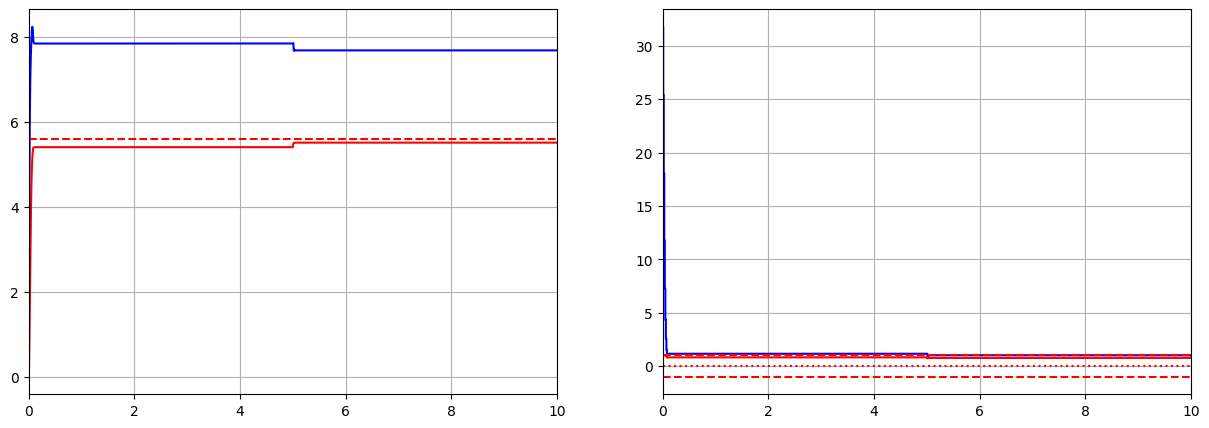

In [9]:
# Параметры для моделирования скачкообразного изменения неконтроллируемого возмущения
di_init = -5
di_finish = 5.5
change_time = 5
# Цель управления
goal = 5.602
# Усиление, характеризующее возможности исполнительного механизма
gain = 370
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Параметры моделирования (время моделирования и начальные условия)
tk=10
x0=[0, 0]
# Функция для моделирования процессов в системе, хранящая информацию о скачкообразном изменении возмущения
func_ctrl = F_with_change(change_time,di_init,di_finish)

# Создание объекта ПЛК
plc = AKAR(goal=goal, gain=gain, dtu=step)
# Моделирование процессов в системе
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
# Построение графиков
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)


Постоянные T_1 и T_2 приняли достаточно малыми, чтобы увеличить скорость процессов в системе. Если принять данные постоянные большими значениями, в системе появляется статическая ошибка. Система стабилизируется очень быстро: при скачкообразном изменении параметра $i$ статическая ошибка стремится к нулю.

### Метод АКАР с интегральной компонентной

Уравнения системы:

$\dot P = -0.1P^3-5P^2-2P+i_0+di+22dV+5$

$\dot dV = 5PdV - 7P - 0.1dv^3-7dV^2-dV+30tanh(F) + 9$

Функции макропеременных:

$\psi_1 = P - Pd$

$\psi_2 = \psi_1 + z = P - Pd + z$

$psi_3 = dV_{internal} - dV$

Эталонные модели:

$T_1 \dot \psi_2 + \psi_2 = 0$

$T_3 \dot \psi_3 + \psi_3 = 0$

Интегральная компонента

$\dot z = \frac 1 {T_2} \psi_1$

Параметр $i$:

$i = i_{min} + \frac{(i_{max}-i_{min})}{2}$

Итоговый закон управления F представлен ниже.

In [10]:
import sympy
from sympy import sin
from sympy.solvers import solve

P = sympy.symbols('P')
dV = sympy.symbols('dV')
F = sympy.symbols('F')
Pd = sympy.symbols('Pd')
i = sympy.symbols('i')
di = sympy.symbols('di')
F = sympy.symbols('F')
G = sympy.symbols('G')

dP = -0.1 * P**3 - 5 * P**2 - 2 * P + di + 22 * dV + 16.5
ddV = 5 * P * dV - 7 * P -0.1 * dV**3 - 7 * dV ** 2 -dV + G * F + 9

T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')
T_3 = sympy.symbols('T_3')
z  = sympy.symbols('z')

psi1  = P - Pd
dz = 1/T_2 * psi1
psi2 = psi1 + z
dpsi2 = sympy.diff(psi2,P)*dP + sympy.diff(psi2, z)*dz
dVd    = solve(sympy.expand(T_1*dpsi2 + psi2), dV)
print("Закон внутреннего управления")
print(str(dVd))

psi3  = dVd[0] - dV
dpsi3 = sympy.diff(psi3,P)*dP + sympy.diff(psi3,dV)*ddV + sympy.diff(psi3,z)*dz
u     = solve(sympy.expand(T_3*dpsi3 + psi3),F)

u_analytical = u[0]
print("Закон управления по методу АКАР")
print('F='+str(sympy.expand(u_analytical)))
print()

Закон внутреннего управления
[0.00454545454545455*(T_1*T_2*(P**3 + 50.0*P**2 + 20.0*P - 10.0*di - 165.0) + 10.0*T_1*(-P + Pd) + 10.0*T_2*(-P + Pd - z))/(T_1*T_2)]
Закон управления по методу АКАР
F=-0.00136363636363636*P**5/G - 0.113636363636364*P**4/G - 2.30909090909091*P**3/G + 0.00454545454545455*P**3/(G*T_3) + 0.00454545454545455*P**3/(G*T_2) + 0.00454545454545455*P**3/(G*T_1) + 0.3*P**2*dV/G + 0.0136363636363636*P**2*di/G - 1.13863636363636*P**2/G + 0.227272727272727*P**2/(G*T_3) + 0.227272727272727*P**2/(G*T_2) + 0.227272727272727*P**2/(G*T_1) + 5.0*P*dV/G + 0.454545454545455*P*di/G + 14.3181818181818*P/G + 0.0909090909090909*P/(G*T_3) + 0.0909090909090909*P/(G*T_2) - 0.0454545454545455*P/(G*T_2*T_3) + 0.0909090909090909*P/(G*T_1) - 0.0454545454545455*P/(G*T_1*T_3) - 0.0454545454545455*P/(G*T_1*T_2) + 0.0454545454545455*Pd/(G*T_2*T_3) + 0.0454545454545455*Pd/(G*T_1*T_3) + 0.0454545454545455*Pd/(G*T_1*T_2) + 0.1*dV**3/G + 7.0*dV**2/G + 3.0*dV/G + 0.0909090909090909*di/G - 7.5/G - 1

Определим регулятор.

In [11]:
class AKAR_i(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt, T_1, T_2, T_3, di):
        super(AKAR_i,self).__init__(gain, dt)
        self.dt = dt
        self.G=gain
        self.Pd=goal
        self.T_1 = T_1
        self.T_2 = T_2
        self.T_3 = T_3
        self.di = di
        self.z = []
        self.zt = []
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        P = x[0]
        dV = x[1]
        T_1 = self.T_1
        T_2 = self.T_2
        T_3 = self.T_3
        Pd = self.Pd
        G = self.G
        di = self.di
        dt = self.dt

        if len(self.z) < 1:
            z = 0.0
        else:
            z = self.z[-1] + dt/T_2*(P - Pd)
        self.z.append(z)
        self.zt.append(t)
        return self.func(
            G=G, T_2=T_2, P=P, di=di, Pd=Pd, z=z, dV=dV, T_3=T_3, T_1=T_1
        )

Проведём моделирование.

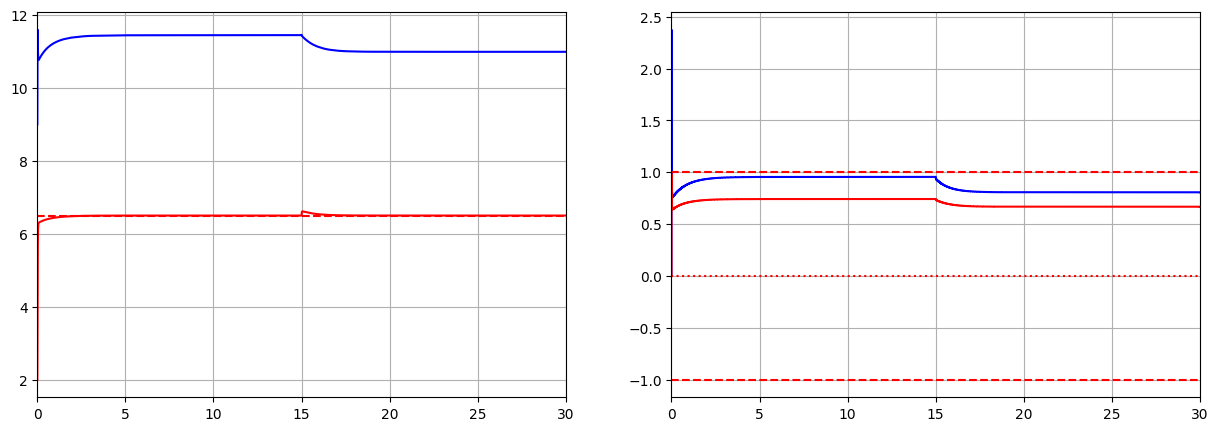

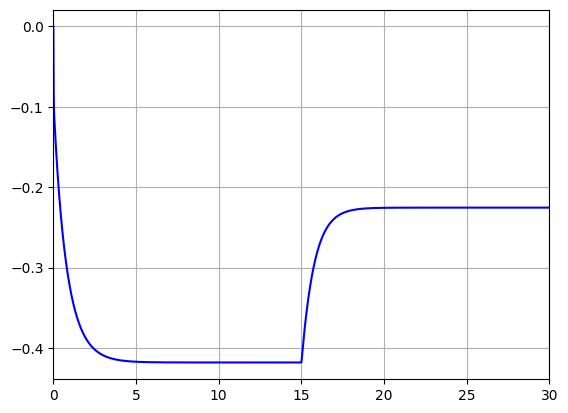

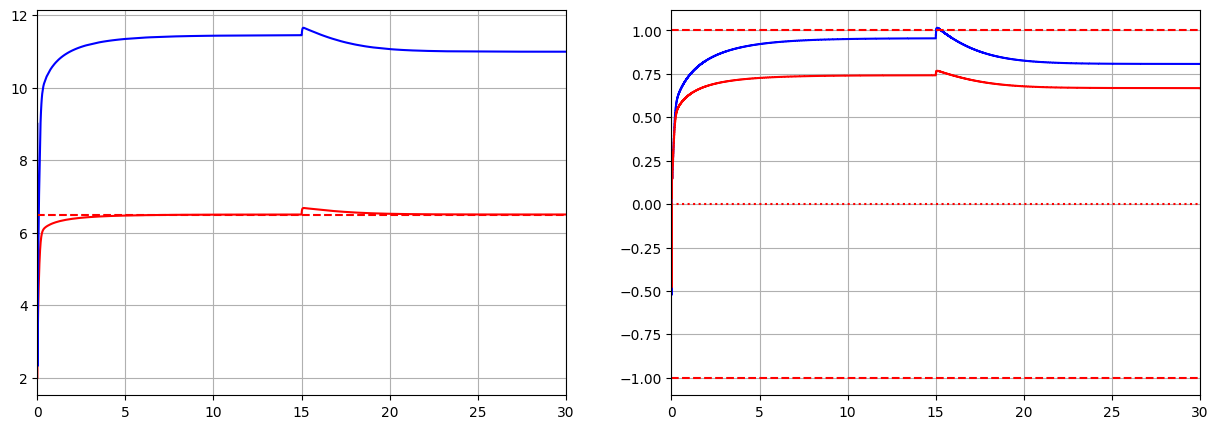

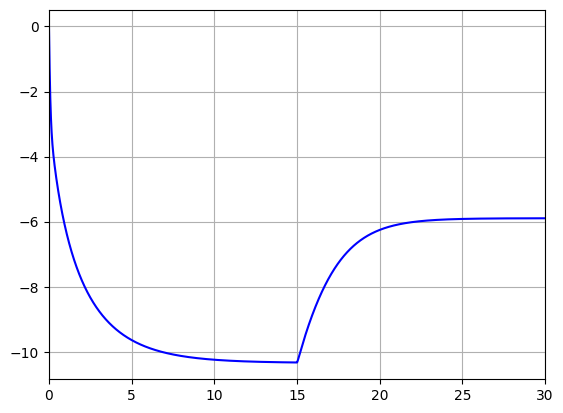

In [12]:
# Параметры для моделирования скачкообразного изменения неконтроллируемого возмущения
di_init = -5.0
di_finish = 5.0
change_time = 15
# Цель управления
goal = 6.5
# Усиление, характеризующее возможности исполнительного механизма
gain = 1000
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Параметры моделирования (время моделирования и начальные условия)
tk=30
x0=[2, 9]
# Функция для моделирования процессов в системе, хранящая информацию о скачкообразном изменении возмущения
func_ctrl = F_with_change(change_time,di_init,di_finish)

reg = AKAR_i(goal=goal, gain=gain, dt=step, T_1=0.005, T_2=0.5, T_3=0.01, di=0)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.grid()
plt.show()

reg = AKAR_i(goal=goal, gain=gain, dt=step, T_1=0.005, T_2=0.1, T_3=0.3, di=0)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.grid()
plt.show()

На графиках видно, что статическая ошибка стала меньше, чем в системе без интегральной адаптации. Увеличение постоянной времени Т_3 делает процессы медленнее.

### Метод АКАР с идентификацией неизмеряемого параметра

In [19]:
a = sympy.symbols('a')

dP=a*P**3-5*P**2-2*P+i+22*dV+5
ddV=5*P*dV-7*P-0.1*dV*3-7*dV**2-dV+G*F+9

psi_1 = P - Pd
dpsi_1 = sympy.diff(psi_1, P)*dP
dmi = solve(sympy.expand(T_1*dpsi_1 + psi_1), dV)
print(f'dV = {str(dmi[0])}')
psi_2 = dmi[0] - dV
dpsi_2 = sympy.diff(psi_2, P)*dP + sympy.diff(psi_2,dV)*ddV
u = solve(sympy.expand(T_2*dpsi_2 + psi_2), F)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'F = {str(u_analytical)}')

dV = (-P + Pd + T_1*(-P**3*a + 5*P**2 + 2*P - i - 5))/(22*T_1)
psi_2 = -dV + (-P + Pd + T_1*(-P**3*a + 5*P**2 + 2*P - i - 5))/(22*T_1)
F = 0.00909090909090909*(-5.0*P + 5.0*Pd + T_1*T_2*(-15.0*P**5*a**2 + 125.0*P**4*a + 40.0*P**3*a - 250.0*P**3 - 330.0*P**2*a*dV - 15.0*P**2*a*i - 75.0*P**2*a - 150.0*P**2 + 550.0*P*dV + 50.0*P*i + 1000.0*P + 770.0*dV**2 + 363.0*dV + 10.0*i - 940.0) + 5.0*T_1*(-P**3*a + 5.0*P**2 + 2.0*P - 22.0*dV - i - 5.0) + 5.0*T_2*(-P**3*a + 5.0*P**2 + 2.0*P - 22.0*dV - i - 5.0))/(G*T_1*T_2)


In [24]:
import sklearn.linear_model as linmod

class ADCS_ident(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt):
        super(ADCS_ident,self).__init__(gain, dt)
        self.G = gain
        self.Pd = goal
        self.x_history = []
        self.x_history_len = 100
        self.dt = dt
        self.coeff = {'t':[0.0], 'a':[-0.1], 'b':[6.0]}
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def transform(self, x, t):
        return [x[0], x[1], math.pow(x[0],3.0)]

    def identification(self, x, t):
        self.x_history.append(x)
        if len(self.x_history) > self.x_history_len:
            self.x_history.pop(0)
        if len(self.x_history) > 1:
            z = np.array([self.transform(zi, t) for zi in (np.array(self.x_history)[:-1])])
            y = np.diff(np.array(self.x_history),axis=0)/self.dt
            y1 = y[:,0] - 22*z[:,1] + 5*z[:,0]*z[:,0] + 2*z[:,0] - 5
            model = linmod.LinearRegression()
            model.fit(X=z[:,2].reshape(-1,1), y=y1)
            self.coeff['t'].append(t)
            a = model.coef_
            if isinstance(a, np.ndarray):
                a = a[0]
            self.coeff['a'].append(a)
            self.coeff['b'].append(model.intercept_)

    def control(self, x, t):
        self.identification(x, t)
        i = self.coeff['b'][-1]
        a = self.coeff['a'][-1]
        P = x[0]
        G = self.gain
        dV = x[1]
        Pd = self.Pd
        u = self.func(
            T_1=3.0, P=P, dV=dV, Pd=Pd, G=G, T_2=1.0, a=a, i=i
        )
        return u

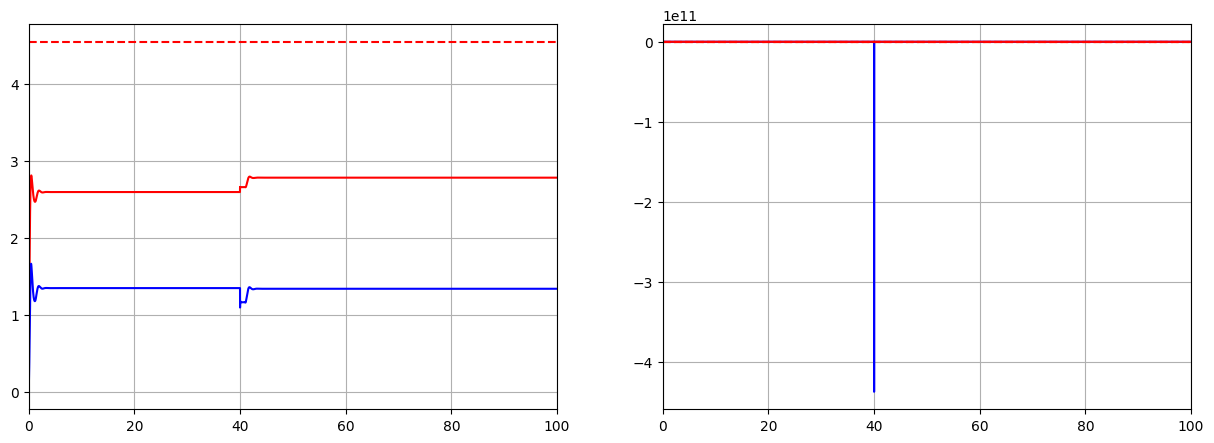

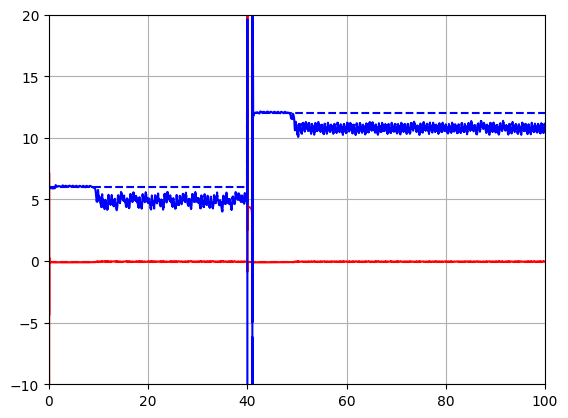

In [47]:
# Параметры для моделирования скачкообразного изменения неконтроллируемого возмущения
di_init = 6.0
di_finish = 12.0
change_time = 40
# Цель управления 
goal = 4.55
# Усиление
gain = 20
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Параметры моделирования (время моделирования и начальные условия)
tk = 100
x0 = [0, 0]
func_ctrl = F_with_change(change_time,di_init,di_finish)

reg = ADCS_ident(goal=goal, gain=gain, dt=step)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.coeff['t'], reg.coeff['a'], 'r', [0, tk], [-0.1, -0.1], 'r--',
         reg.coeff['t'], reg.coeff['b'], 'b', [0, change_time, change_time, tk], [di_init, di_init, di_finish, di_finish], 'b--')
plt.ylim([-10.0, 20.0])
plt.xlim([0, tk])
plt.grid()
plt.show()

### Система прямого адаптивного управления с обобщенной ошибкой настройки

In [13]:
class ADCS_gerr(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_gerr,self).__init__(gain,step=dt)
        self.g = speed
        self.Pd = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'dy':[], 'ddy':[], 'sigma':[]}
        self.y_last = None
        self.y_last_last = None

    def optimize(self, x, t):
        y = x[0] - self.Pd
        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        if self.y_last_last is not None:
            dy = (y - self.y_last)/self.dt
            ddy = (y - 2.0*self.y_last + self.y_last_last) / (self.dt**2)
            sigma = ddy + 100.0*dy + 50*y
            self.coeff['sigma'].append(sigma)

            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]

            c1 = c1 - self.g*sigma*x[0]
            c2 = c2 - self.g*sigma*x[1]
            c3 = c3 - self.g*sigma

            self.coeff['c1'].append(c1)
            self.coeff['c2'].append(c2)
            self.coeff['c3'].append(c3)
        else:
            self.coeff['sigma'].append(0.0)
            self.coeff['c1'].append(self.c10)
            self.coeff['c2'].append(self.c20)
            self.coeff['c3'].append(self.c30)

        if self.y_last is not None:
            self.y_last_last = self.y_last

        self.y_last = y

    def control(self, x, t):
        self.optimize(x, t)

        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]

        return c1*x[0] + c2*x[1] + c3

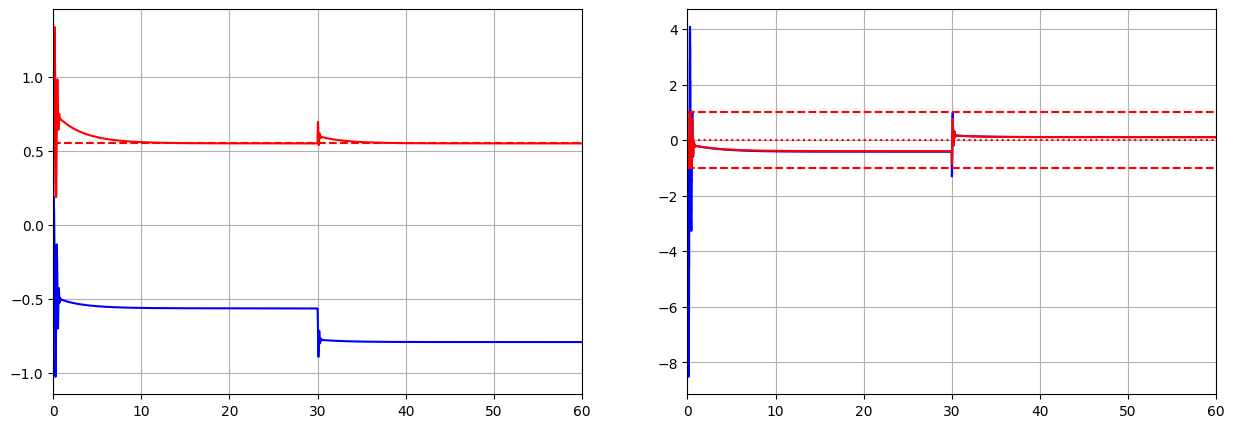

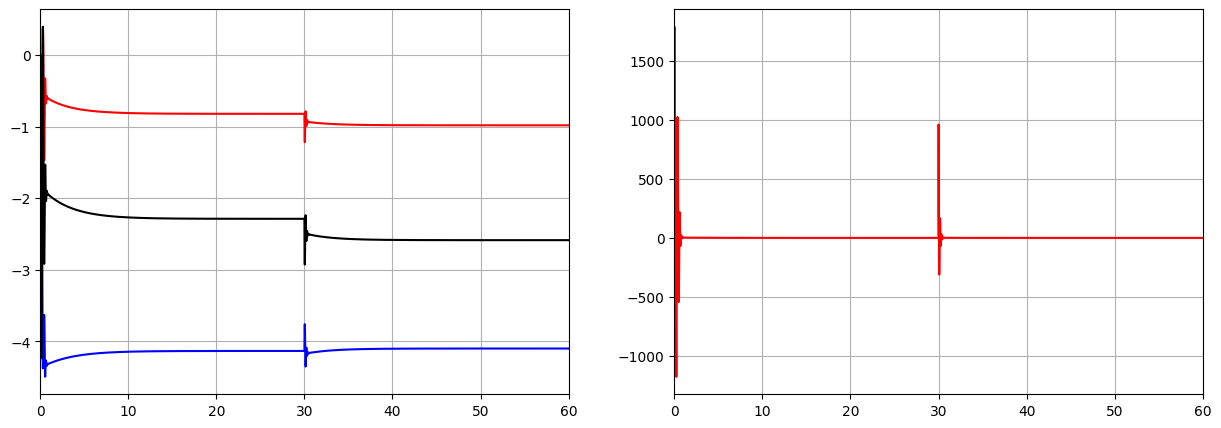

In [18]:
# Параметры для моделирования скачкообразного изменения неконтроллируемого возмущения
di_init = 10.0
di_finish = 15.0
change_time = 30
# Цель управления 
goal = 0.55
# Усиление
gain = 5
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Параметры моделирования (время моделирования и начальные условия)
tk = 60
x0 = [0, 0]
func_ctrl = F_with_change(change_time,di_init,di_finish)

reg = ADCS_gerr(goal=goal, gain=gain, dt=step, speed=0.0004)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',# [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['c2'], 'b',# [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['sigma'], 'r')# [0, tk], [-1, -1], 'r--',
plt.grid()
plt.xlim([0, tk])
plt.show()

### Система прямого адаптивного управления на базе алгоритма скоростного градиента

In [48]:
class ADCS_spgrad(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_spgrad,self).__init__(gain, dt)
        self.g = speed
        self.Pd = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'Q':[]}

    def optimize(self, x, t):
        y = x[0] - self.Pd
        Q = y**2

        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        self.coeff['Q'].append(Q)

        if len(self.coeff['c1'])>0:
            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]
        else:
            c1 = 0.0
            c2 = 0.0
            c3 = 0.0

        c1 = c1 - self.g*y*x[0]
        c2 = c2 - self.g*y*x[1]
        c3 = c3 - self.g*y

        self.coeff['c1'].append(c1)
        self.coeff['c2'].append(c2)
        self.coeff['c3'].append(c3)

    def control(self, x, t):
        self.optimize(x, t)

        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]

        return c1*x[0] + c2*x[1] + c3

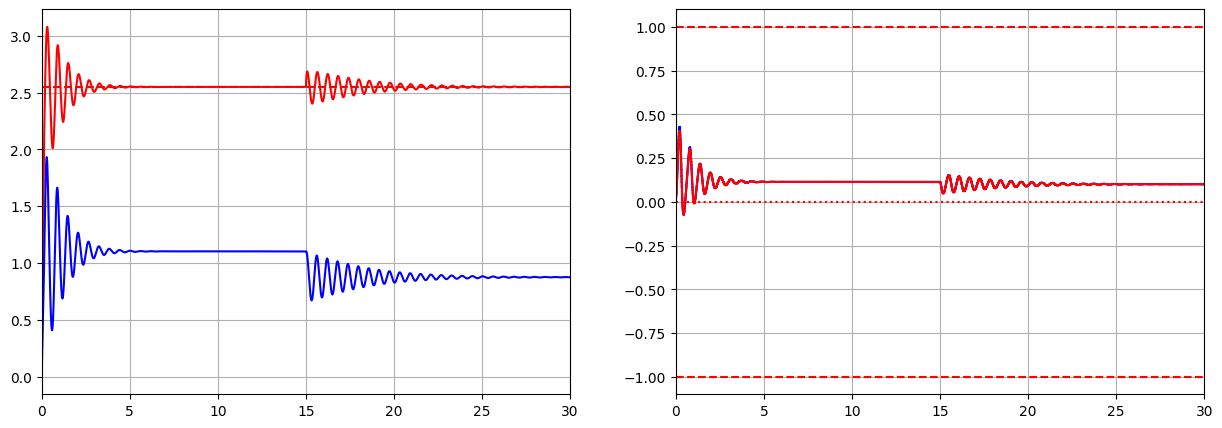

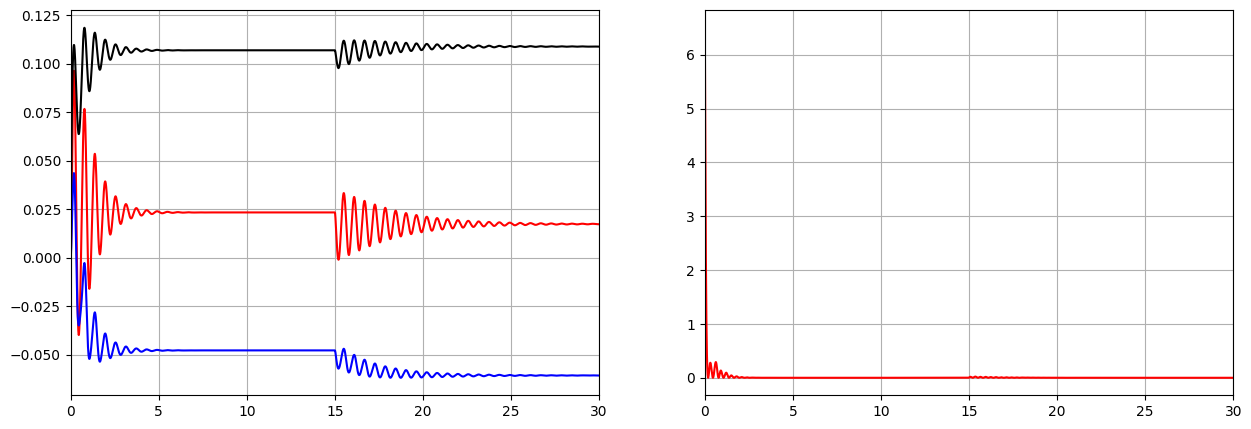

In [74]:
# Параметры для моделирования скачкообразного изменения неконтроллируемого возмущения
di_init = 10.0
di_finish = 15.0
change_time = 15
# Цель управления 
goal = 2.55
# Усиление
gain = 40
# Задание времени одного такта работы ПЛК и шага моделирования процессов
step = 0.01
mod_step = 0.001
# Параметры моделирования (время моделирования и начальные условия)
tk = 30
x0 = [0, 0]
func_ctrl = F_with_change(change_time,di_init,di_finish)

reg = ADCS_spgrad(goal=goal, gain=gain, dt=step, speed=0.005)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',
         reg.coeff['t'], reg.coeff['c2'], 'b',
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['Q'], 'r')
plt.grid()
plt.xlim([0, tk])
plt.show()